C:\Users\NegahdN\AppData\Local\Temp\ipykernel_26968\3415090813.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['lon'] = merged.geometry.centroid.x
C:\Users\NegahdN\AppData\Local\Temp\ipykernel_26968\3415090813.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['lat'] = merged.geometry.centroid.y


Saved: fort_worth_tracts_with_rent.geojson


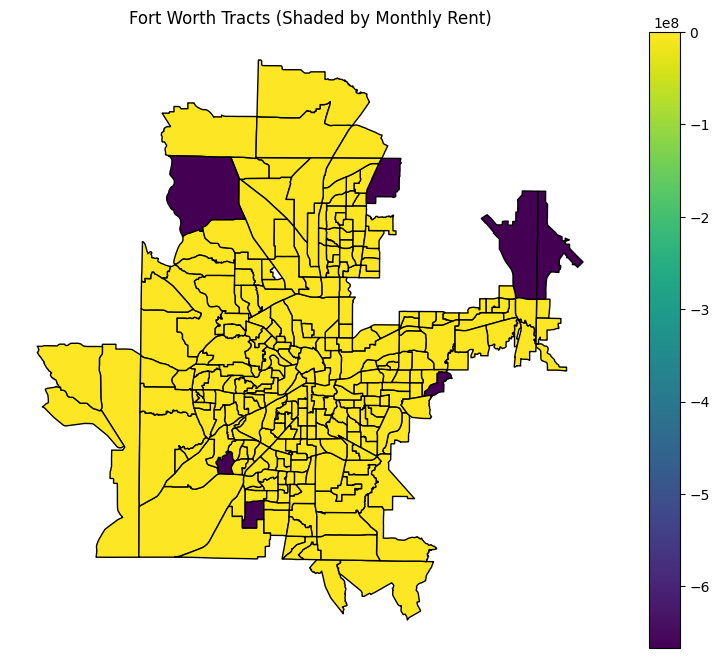

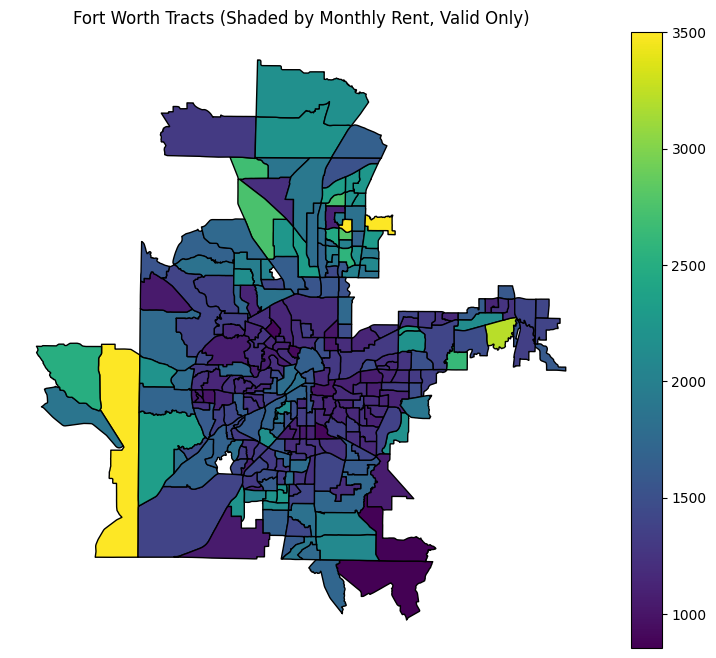

In [7]:
import geopandas as gpd
import censusdata

# 1. Load ALL Texas census tracts
tracts = gpd.read_file("tl_2023_48_tract.shp")  # Statewide

# 2. Load all Texas places, select Fort Worth
places = gpd.read_file("tl_2023_48_place.shp")
fort_worth = places[places["NAME"] == "Fort Worth"].to_crs(tracts.crs)


# 3. Spatial join: select ALL tracts that intersect the city boundary
tracts_in_fw = gpd.sjoin(tracts, fort_worth, predicate="intersects")
if 'index_right' in tracts_in_fw.columns:
    tracts_in_fw = tracts_in_fw.drop(columns='index_right')


# 4. Download median gross rent data for all tracts in Texas (this is a bit slower but complete)
df = censusdata.download(
    'acs5', 2023,
    censusdata.censusgeo([('state', '48'), ('tract', '*')]),
    ['B25064_001E']
)

df = df.reset_index()
df.rename(columns={'index': 'geo', 'B25064_001E': 'monthly_rent'}, inplace=True)
df['tract'] = df['geo'].apply(lambda g: g.geo[2][1])
df['county'] = df['geo'].apply(lambda g: g.geo[1][1])  # May need for merge

# 5. Merge on BOTH TRACTCE and COUNTYFP (for uniqueness in Texas)
tracts_in_fw['TRACTCE'] = tracts_in_fw['TRACTCE'].astype(str)
tracts_in_fw['COUNTYFP'] = tracts_in_fw['COUNTYFP'].astype(str)
df['tract'] = df['tract'].astype(str)
df['county'] = df['county'].astype(str)

merged = tracts_in_fw.merge(df, left_on=['TRACTCE','COUNTYFP'], right_on=['tract','county'])

# 6. Optional: Clean up and export
merged['lon'] = merged.geometry.centroid.x
merged['lat'] = merged.geometry.centroid.y

output_gdf = merged[['monthly_rent', 'lat', 'lon', 'geometry']].copy()
output_gdf.to_file("fort_worth_tracts_with_rent.geojson", driver="GeoJSON")

print("Saved: fort_worth_tracts_with_rent.geojson")
# -----------------------
# 6. (Optional) Quick Plot to Check Output
# -----------------------
import matplotlib.pyplot as plt

# Plot all tracts in Fort Worth (including invalid rents)
output_gdf.plot(column='monthly_rent', legend=True, cmap='viridis', edgecolor='black', figsize=(10, 8))
plt.title("Fort Worth Tracts (Shaded by Monthly Rent)")
plt.axis('off')
plt.show()

# Plot only tracts with valid (positive) rent values
output_gdf[output_gdf['monthly_rent'] > 0].plot(
    column='monthly_rent', legend=True, cmap='viridis', edgecolor='black', figsize=(10, 8)
)
plt.title("Fort Worth Tracts (Shaded by Monthly Rent, Valid Only)")
plt.axis('off')
plt.show()

Generated 2268 grid pieces within Fort Worth tracts.


C:\Users\NegahdN\AppData\Local\Temp\ipykernel_26968\787587106.py:42: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


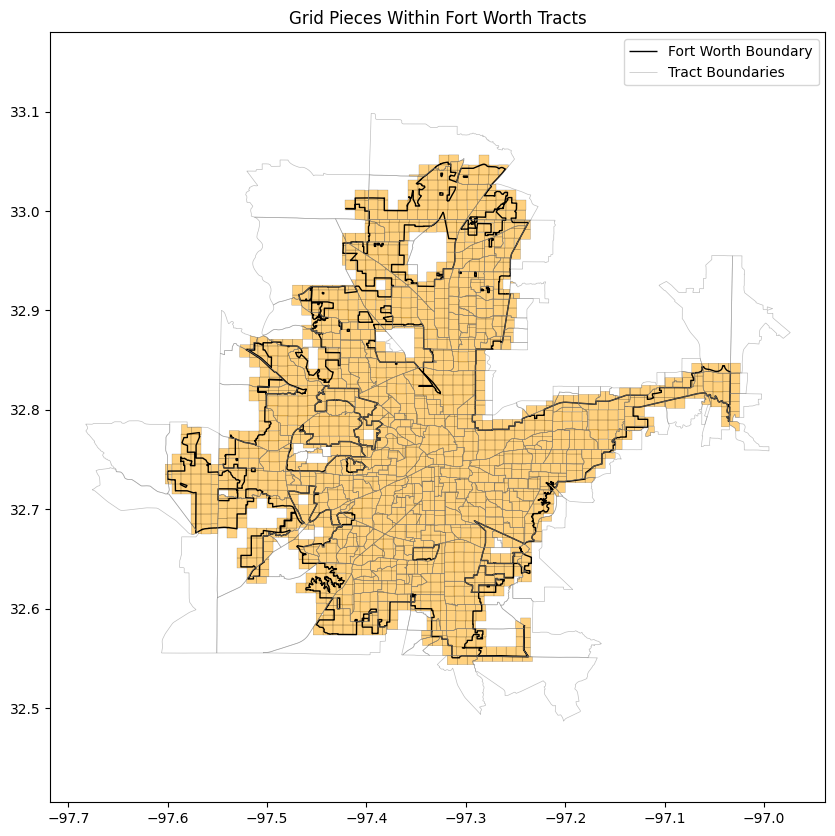

In [6]:
from shapely.geometry import box
import numpy as np

# Divide each tract into smaller pieces (e.g., using a grid of points or polygons), then select only those pieces within the Fort Worth city boundary


# Set grid size (in degrees, e.g., ~0.01 is about 1km, adjust as needed)
grid_size = 0.01

# List to hold grid pieces within Fort Worth
grid_pieces = []

# Loop through each tract in Fort Worth
for idx, tract in tracts_in_fw.iterrows():
    bounds = tract.geometry.bounds  # (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = bounds
    # Create grid cells within the tract's bounding box
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + grid_size, y + grid_size)
            # Only keep cell if it intersects both the tract and the city boundary
            if tract.geometry.intersects(cell) and fort_worth.iloc[0].geometry.intersects(cell):
                # Optionally, clip the cell to the tract geometry
                clipped = cell.intersection(tract.geometry)
                if not clipped.is_empty:
                    grid_pieces.append({'tract': tract['TRACTCE'], 'geometry': clipped})

# Create GeoDataFrame of grid pieces within city boundary
grid_gdf = gpd.GeoDataFrame(grid_pieces, crs=tracts_in_fw.crs)

print(f"Generated {len(grid_gdf)} grid pieces within Fort Worth tracts.")
grid_gdf.head()
# Plot the generated grid pieces within Fort Worth tracts
fig, ax = plt.subplots(figsize=(10, 10))
fort_worth.boundary.plot(ax=ax, color='black', linewidth=1, label='Fort Worth Boundary')
tracts_in_fw.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5, label='Tract Boundaries')
grid_gdf.plot(ax=ax, color='orange', alpha=0.5, edgecolor='k', linewidth=0.2, label='Grid Pieces')
plt.title("Grid Pieces Within Fort Worth Tracts")
plt.axis('equal')
plt.legend()
plt.show()
# Save the grid pieces to a GeoJSON file
grid_gdf.to_file("fort_worth_grid_pieces.geojson", driver="GeoJSON")

Saved fort_worth_grid_pieces.geojson with rent info! Count: 2268


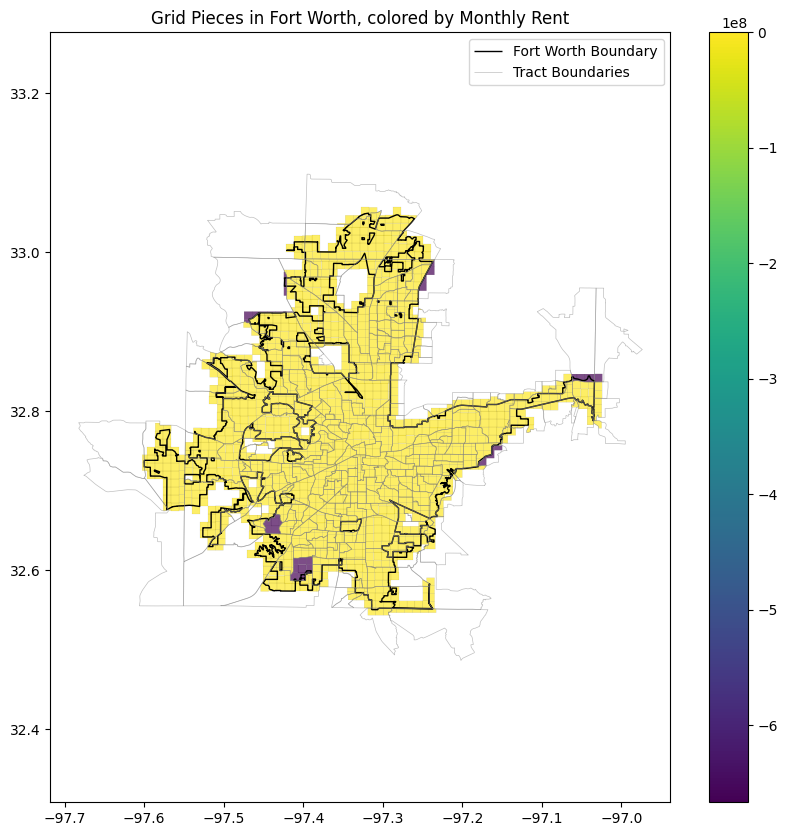

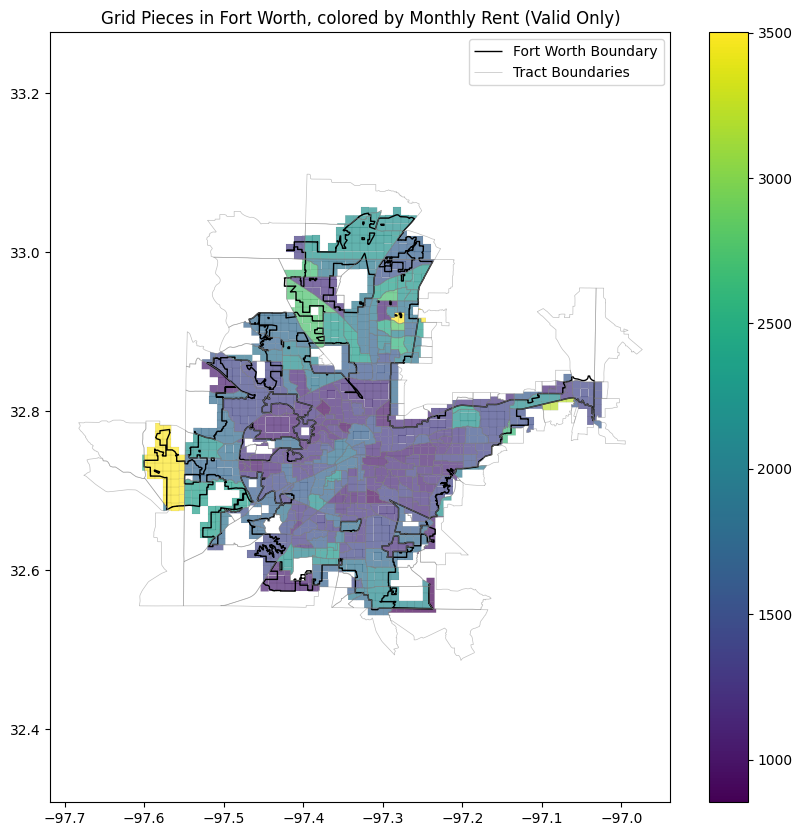

In [ ]:
import geopandas as gpd
import censusdata
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt

# 1. Load ALL Texas census tracts
tracts = gpd.read_file("tl_2023_48_tract.shp")  # Statewide

# 2. Load all Texas places, select Fort Worth
places = gpd.read_file("tl_2023_48_place.shp")
fort_worth = places[places["NAME"] == "Fort Worth"].to_crs(tracts.crs)

# 3. Select tracts that intersect the city boundary
tracts_in_fw = gpd.sjoin(tracts, fort_worth, predicate="intersects")
if 'index_right' in tracts_in_fw.columns:
    tracts_in_fw = tracts_in_fw.drop(columns='index_right')

# 4. Download median gross rent for all Texas tracts
df = censusdata.download(
    'acs5', 2023,
    censusdata.censusgeo([('state', '48'), ('tract', '*')]),
    ['B25064_001E']
)
df = df.reset_index()
df.rename(columns={'index': 'geo', 'B25064_001E': 'monthly_rent'}, inplace=True)
df['tract'] = df['geo'].apply(lambda g: g.geo[2][1])
df['county'] = df['geo'].apply(lambda g: g.geo[1][1])

# 5. Merge rent data onto Fort Worth tracts
tracts_in_fw['TRACTCE'] = tracts_in_fw['TRACTCE'].astype(str)
tracts_in_fw['COUNTYFP'] = tracts_in_fw['COUNTYFP'].astype(str)
df['tract'] = df['tract'].astype(str)
df['county'] = df['county'].astype(str)
tracts_in_fw = tracts_in_fw.merge(df, left_on=['TRACTCE', 'COUNTYFP'], right_on=['tract', 'county'], how='left')

# 6. Divide each tract into grid pieces (e.g., ~1km square)
grid_size = 0.01  # About 1km
grid_pieces = []

for idx, tract in tracts_in_fw.iterrows():
    bounds = tract.geometry.bounds
    minx, miny, maxx, maxy = bounds
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + grid_size, y + grid_size)
            # Only keep if it intersects both tract and city boundary
            if tract.geometry.intersects(cell) and fort_worth.iloc[0].geometry.intersects(cell):
                clipped = cell.intersection(tract.geometry)
                if not clipped.is_empty:
                    # Add the tract's rent to each grid piece
                    grid_pieces.append({
                        'tract': tract['TRACTCE'],
                        'county': tract['COUNTYFP'],
                        'monthly_rent': tract['monthly_rent'],
                        'geometry': clipped
                    })

# 7. Create GeoDataFrame of grid pieces WITH rent info
grid_gdf = gpd.GeoDataFrame(grid_pieces, crs=tracts_in_fw.crs)

# 8. Save to GeoJSON with rent info!
grid_gdf.to_file("fort_worth_grid_pieces.geojson", driver="GeoJSON")
print(f"Saved fort_worth_grid_pieces.geojson with rent info! Count: {len(grid_gdf)}")

# 9. (Optional) Plot
fig, ax = plt.subplots(figsize=(10, 10))
fort_worth.boundary.plot(ax=ax, color='black', linewidth=1, label='Fort Worth Boundary')
tracts_in_fw.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5, label='Tract Boundaries')
grid_gdf.plot(ax=ax, column='monthly_rent', cmap='viridis', alpha=0.7, edgecolor='k', linewidth=0.05, legend=True)
plt.title("Grid Pieces in Fort Worth, colored by Monthly Rent")
plt.axis('equal')
plt.legend()
plt.show()
# Show only grid pieces with valid (positive) rent values
valid_grid_gdf = grid_gdf[grid_gdf['monthly_rent'] > 0]
fig, ax = plt.subplots(figsize=(10, 10))
fort_worth.boundary.plot(ax=ax, color='black', linewidth=1, label='Fort Worth Boundary')
tracts_in_fw.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5, label='Tract Boundaries')
valid_grid_gdf.plot(ax=ax, column='monthly_rent', cmap='viridis', alpha=0.7, edgecolor='k', linewidth=0.05, legend=True)
plt.title("Grid Pieces in Fort Worth, colored by Monthly Rent (Valid Only)")
plt.axis('equal')
plt.legend()
plt.show()
fort_worth.boundary.to_file("fort_worth_boundary.geojson", driver="GeoJSON")
print("Saved: fort_worth_boundary.geojson")
tracts_in_fw.boundary.to_file("fort_worth_tract_boundaries.geojson", driver="GeoJSON")
print("Saved: fort_worth_tract_boundaries.geojson")